# 猫狗大战

这个项目使用 python3.5 + tensorflow 1.0 + gpu环境

In [1]:
# 导入库
import tensorflow as tf
from imp import reload
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display, Image
import time
import sys, traceback

import warnings
warnings.filterwarnings('ignore')

import TFHelper
import CatDogDataset

%matplotlib inline

In [2]:
# 全局变量
IMG_SZ = 108
IMG_FT = IMG_SZ * IMG_SZ * 3
LABTXT = ['Cat', 'Dog', 'NODATA']


# 图像可视化
def visualize(imgs, real=None, pred=None, fsize=2.6, wsize=5):
    if pred is not None:
        pred = pred.reshape(-1)
        predclass = np.piecewise(pred, [pred < 0.5, pred >= 0.5], [0, 1])
 
    size = min(len(imgs), 25)
    hsize = round(size / wsize + .4)   
    fig = plt.figure(figsize=(fsize*wsize, hsize * fsize))
    if imgs.shape[3] == 1:
        imgs = imgs[:, :, :, -1]

    for i in range(0, size):
        fig.add_subplot(hsize, wsize, i + 1) 
        plt.imshow(imgs[i] + .5)  # display it
        plt.axis('off')
        predtxt = ""
        if pred is not None:
            plt.text(0, -4, 'Probably: {}({:.2%})'.format( LABTXT[int(predclass[i])], abs(pred[i] - 0.5) * 2))
        else:
            plt.text(0, -4, 'Real: ' + (real is not None and LABTXT[int(real[i])]))

# 二元精确度
def accuracy(predictions, labels):
    assert(predictions.shape == labels.shape)
    assert(predictions.dtype == labels.dtype)
    pred = np.piecewise(predictions, [predictions < 0.5, predictions >= 0.5], [0, 1])
#     print(pred)
#     print(labels)
#     print(pred == labels, np.sum(pred == labels))
    return 'accuracy', np.sum(pred == labels) / len(labels) * 100

#批次计算精确率
def batch_mean(generator, step, func):
    accs = []
    for i in range(step):
        x,y = next(generator)
        accs.append( func(x, y) )
    print(accs)
    return np.mean(accs)
    
# 图像可视化预测结果
def visualize_predict(clf, generator, fsize=2.6, wsize=5, origin_generator=None):   
    x,y = next(generator)
    predict_lab = clf.predict(x)
    if origin_generator is not None:
        x,_ = next(origin_generator)
    visualize(x, y, predict_lab, fsize, wsize)

skip: train/
skip: train/dog.10237.jpg
skip: test/
train datas:  19999


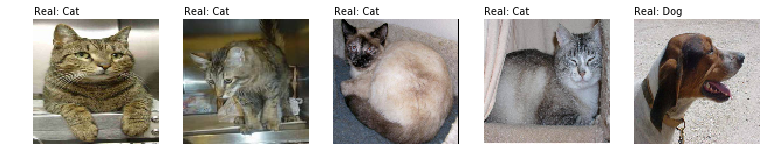

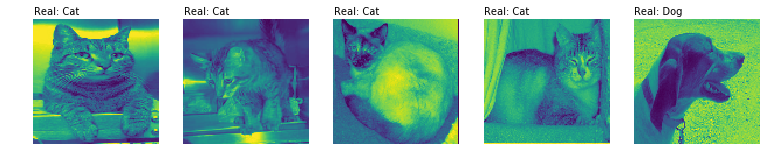

In [3]:
# 数据集准备
CatDogDataset = reload(CatDogDataset)

train, vali, test = CatDogDataset.get_kaggle_reader()
print('train datas: ', train.count)

# 列出数据集里的图 
train_reader = train.get_generator(batch_size=5, image_size=IMG_SZ)
visualize(*next(train_reader))
train_reader = None #clean memory

# 灰度
train_gray_reader = train.get_generator(batch_size=5, image_size=IMG_SZ, gray=True)
visualize(*next(train_gray_reader))
train_gray_reader = None #clean memory

# 检测数据集平衡性

In [4]:
train_labels = train.labels
print(np.sum(train_labels), len(train_labels), 'dog/all:', np.sum(train_labels) / len(train_labels))

10002.0 20000 dog/all: 0.5001


# 使用线性分类 (可跳过执行）

In [4]:
train_reader = train.get_generator(batch_size=128, image_size=IMG_SZ)
vali_reader = vali.get_generator(batch_size=128, image_size=IMG_SZ)
test_reader = test.get_generator(batch_size=500, image_size=IMG_SZ)
total_steps = int(train.count / 128) + 1

%time vali_dat, vali_lab = next(vali_reader)
vali_dat = vali_dat.reshape(-1, IMG_FT)

from sklearn.linear_model import SGDClassifier
linear_clf = SGDClassifier(penalty='elasticnet', loss='log')

start = time.time()
try:
    for batch in range(0, total_steps):
        dat, lab = next(train_reader)
        dat = dat.reshape(-1, IMG_FT)
        linear_clf.partial_fit(dat, lab, [0,1])
        TFHelper.step_info(batch + 1, total_steps, 
                  {'accuracy': str(round(linear_clf.score(vali_dat, vali_lab)*100, 2)) + '%' })
    print('\nend ', str(time.time() - start), 's')
except Exception as e:
    print('\nerror', e, traceback.format_exc(), str)

Wall time: 818 ms
--== Step: 157/157 (100.0%) Score: accuracy 57.03% ==-- 
end  193.4295518398285 s


In [5]:
from sklearn.metrics import accuracy_score

print('validation accuracy is:', 
      batch_mean( vali_reader, 10, lambda x, y: accuracy(
                                   linear_clf.predict(x.reshape(-1, IMG_FT)),
                                   y[:, -1].astype(int) )[1] ))

[59.375, 47.65625, 55.46875, 59.375, 53.90625, 48.4375, 52.34375, 51.5625, 53.125, 50.0]
validation accuracy is: 53.125


# 使用深度学习

In [30]:
# 准备数据
import CatDogDataset
CatDogDataset = reload(CatDogDataset)
IMG_SZ = 108

train_reader = train.get_generator(batch_size=108, image_size=IMG_SZ)
vali_reader = vali.get_generator(batch_size=32, image_size=IMG_SZ)
test_reader = test.get_generator(batch_size=32, image_size=IMG_SZ)

%time vali_dat, vali_lab = next(vali_reader)

Wall time: 148 ms


In [5]:
TFHelper = reload(TFHelper)
Layer = TFHelper.Layer

def my_loss_func(logits, tf_train_labs):
    return tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(
            logits=logits, labels=tf_train_labs))

# Main Model
def my_model(x_input, drop=None):
    depth = (64, 128, 256, 512, 128, 64)
    with tf.variable_scope("conv1a"):
        net = Layer.conv_relu(x_input, kernel_shape=[3, 3, 3, depth[0]])
    with tf.variable_scope("conv1b"):
        net = Layer.conv_relu(net, kernel_shape=[3, 3, depth[0], depth[0]])
        net = Layer.pool(net)
    Layer.split()
        
    with tf.variable_scope("conv2a"):
        net = Layer.conv_relu(net, kernel_shape=[3, 3, depth[0], depth[1]])
    with tf.variable_scope("conv2b"):
        net = Layer.conv_relu(net, kernel_shape=[3, 3, depth[1], depth[1]])
        net = Layer.pool(net)
    Layer.split()
    
    with tf.variable_scope("conv3a"):
        net = Layer.conv_relu(net, kernel_shape=[3, 3, depth[1], depth[2]])
    with tf.variable_scope("conv3b"):
        net = Layer.conv_relu(net, kernel_shape=[3, 3, depth[2], depth[2]])
#     with tf.variable_scope("conv3c"):
#         net = Layer.conv_relu(net, kernel_shape=[3, 3, depth[2], depth[2]])
#     with tf.variable_scope("conv3d"):    
#         net = Layer.conv_relu(net, kernel_shape=[3, 3, depth[2], depth[2]])
        net = Layer.pool(net)
    Layer.split()
    
    with tf.variable_scope("conv4a"):
        net = Layer.conv_relu(net, kernel_shape=[3, 3, depth[2], depth[3]])
    with tf.variable_scope("conv4b"):
        net = Layer.conv_relu(net, kernel_shape=[3, 3, depth[3], depth[3]])
#     with tf.variable_scope("conv4c"):
#         net = Layer.conv_relu(net, kernel_shape=[3, 3, depth[3], depth[3]])
#     with tf.variable_scope("conv4d"):    
#         net = Layer.conv_relu(net, kernel_shape=[3, 3, depth[3], depth[3]])
        net = Layer.pool(net)
    Layer.split()
    
    with tf.variable_scope("conv5a"):
        net = Layer.conv_relu(net, kernel_shape=[3, 3, depth[3], depth[3]])
    with tf.variable_scope("conv5b"):
        net = Layer.conv_relu(net, kernel_shape=[3, 3, depth[3], depth[3]])
#     with tf.variable_scope("conv5c"):
#         net = Layer.conv_relu(net, kernel_shape=[3, 3, depth[3], depth[3]])
#     with tf.variable_scope("conv5d"):    
#         net = Layer.conv_relu(net, kernel_shape=[3, 3, depth[3], depth[3]])
        net = Layer.pool(net)        
    Layer.split()
    
    with tf.variable_scope("flat"):
        net = Layer.flat(net)
        net = Layer.relu(net, out_size=depth[4])
        net = Layer.drop(net, drop)
    Layer.split()
    
    with tf.variable_scope("relu1"):
        net = Layer.relu(net, out_size=depth[4])
    Layer.split()
    
    with tf.variable_scope("relu2"):
        net = Layer.relu(net, out_size=depth[5])
    Layer.split()
    
    with tf.variable_scope("out"):
        weights, biases = Layer.var([depth[5], 1]) 
        logits = tf.matmul(net, weights) + biases
    
    return {
        'logits': logits,
        'predict': tf.nn.sigmoid(logits),
    }

clf = TFHelper.Learner(my_model, accuracy, 'catdog',
                       steps=6010, learning_rate=0.001,
                       loss=my_loss_func,
                       optimizer=tf.train.AdamOptimizer,
                       drop=0.85
                     )

clf.fit_generator(train_reader, vali_dat, vali_lab, restore=True)

(108, 108, 108, 3)
Tensor("PlaceholderWithDefault:0", dtype=float32)
Tensor("Placeholder:0", dtype=float32)
Tensor("model/Sigmoid:0", shape=(?, 1), dtype=float32)


Reshape:0,"[108, 108, 3]"
model/conv1a/Conv2D:0,"[108, 108, 64]"
model/conv1b/Conv2D:0,"[108, 108, 64]"
model/conv1b/MaxPool:0,"[54, 54, 64]"
---,---
model/conv2a/Conv2D:0,"[54, 54, 128]"
model/conv2b/Conv2D:0,"[54, 54, 128]"
model/conv2b/MaxPool:0,"[27, 27, 128]"
---,---
model/conv3a/Conv2D:0,"[27, 27, 256]"
model/conv3b/Conv2D:0,"[27, 27, 256]"


Initialized
--== Step: 0/6010 (0.0%) Score: loss 0.0817651, train accuracy 95.3703703704, vail accuracy 100.0 ==-- 

KeyboardInterrupt: 

In [6]:
#评分n*64个vali集上的图像
batch_mean(vali_reader, 30, lambda x, y: accuracy( clf.predict(x), y )[1] )

[93.75, 96.875, 96.875, 84.375, 96.875, 96.875, 96.875, 93.75, 93.75, 93.75, 93.75, 90.625, 96.875, 90.625, 93.75, 96.875, 87.5, 100.0, 96.875, 96.875, 96.875, 93.75, 90.625, 96.875, 100.0, 96.875, 93.75, 87.5, 96.875, 100.0]


94.6875

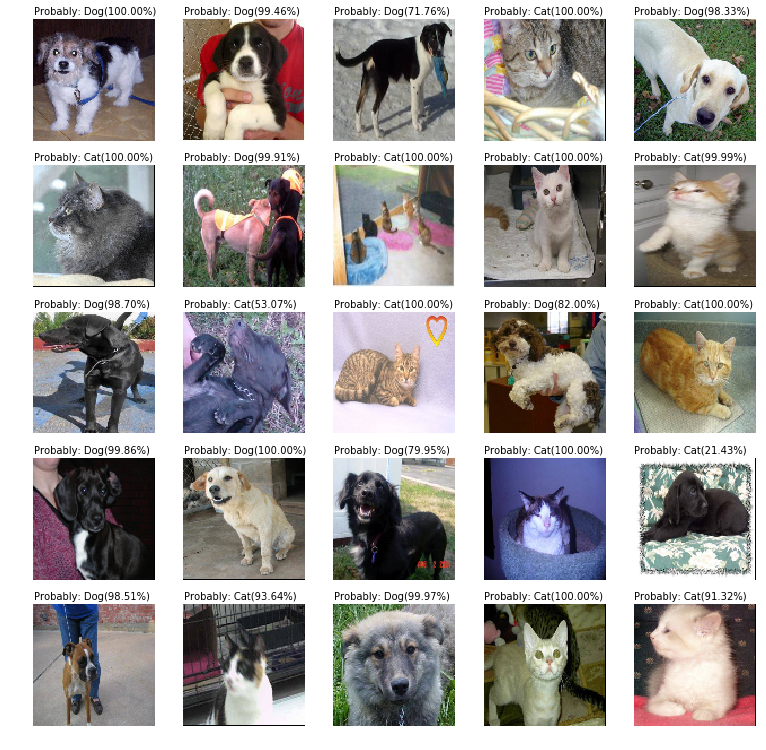

In [27]:
#随机预测25张图显示出来
visualize_predict(clf, test_reader)

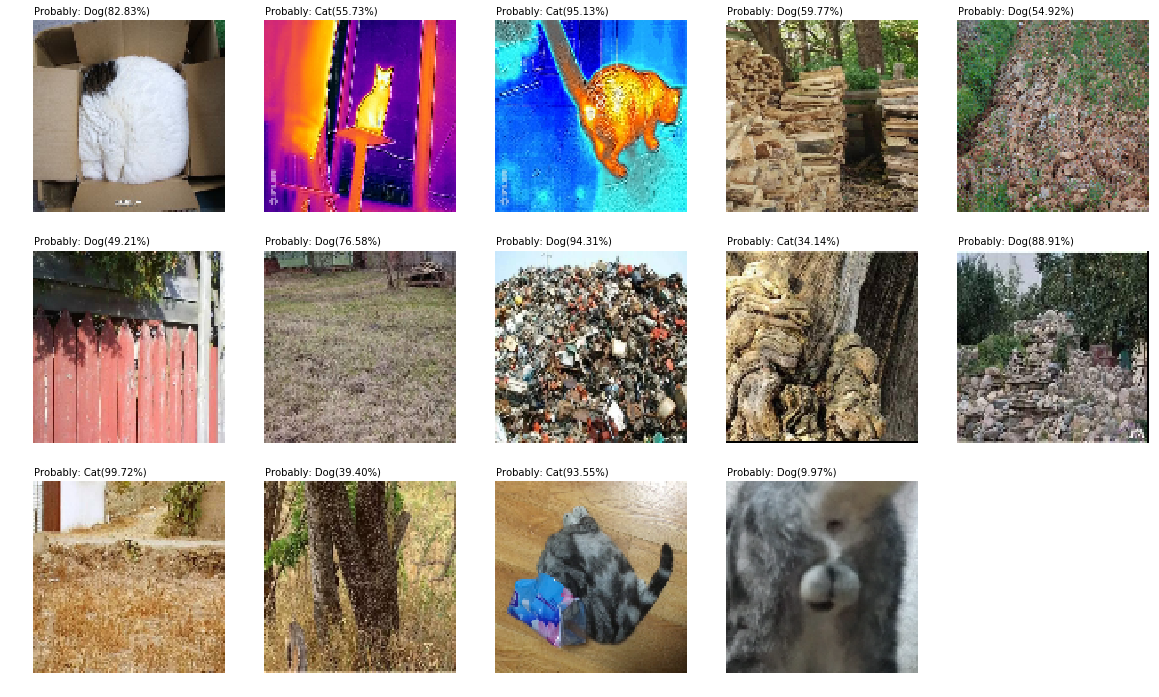

In [56]:
# 实验几张自己的图片
cats = CatDogDataset.get_reader('./cats.zip')
cats_reader = cats.get_generator(batch_size=cats.count, image_size=IMG_SZ)
visualize_predict(clf, cats_reader, 4)

# 实验小型ResNet


In [11]:
# 准备数据
import CatDogDataset
CatDogDataset = reload(CatDogDataset)
IMG_SZ = 224

batch_size = 128
iter = lambda x: int(train.count / batch_size * x)
train_reader = train.get_generator(batch_size=batch_size, image_size=IMG_SZ)
vali_reader = vali.get_generator(batch_size=32, image_size=IMG_SZ)
test_reader = test.get_generator(batch_size=32, image_size=IMG_SZ)

%time vali_dat, vali_lab = next(vali_reader)

Wall time: 218 ms


In [25]:
import rsnn
TFHelper = reload(TFHelper)
Layer = TFHelper.Layer
Layer.stddev = 0.02

# 通过rsnn.py加载模型层
def rsnn_layer(x, rsnn):
    x_input = x
    for i in range(rsnn['repeat']):
        with tf.variable_scope("repeat"+str(i)):
            for j, l in enumerate(rsnn['layers']):
                stride = (i == 0 and j == 0) and rsnn['stride'] or 1
                with tf.variable_scope("layer"+str(j)):
                    x = Layer.conv_relu(x, kernel_shape=[l.ksize, l.ksize, x.get_shape()[-1], l.out], 
                                        stride=stride, padding=l.pad)

            if i == 0:
                l1 = rsnn['layers'][0]
                x_input = Layer.conv_relu(x_input, 
                                          kernel_shape=[l1.ksize, l1.ksize, 
                                                        x_input.get_shape()[-1], rsnn['layers'][-1].out], 
                                          stride=rsnn['stride'], padding=l1.pad)
            try:
                x = x + x_input
            except Exception as e:
                TFHelper.print_tree()
                print(e)
                raise e
            TFHelper.add_display_tree(x, 'shortcut')
    return x
        

            
def my_loss_func(logits, tf_train_labs):
    return tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(
            logits=logits, labels=tf_train_labs))

# Main Model
def my_rsnn_model(x_input, drop=None):
    depth = 64
    with tf.variable_scope("conv1"):
        net = Layer.conv_relu(x_input, kernel_shape=[7, 7, 3, depth], stride=2)
        net = Layer.pool(net, ksize = 3)
    Layer.split()
    
    rsnn_st = rsnn.rsnn18
    
    with tf.variable_scope("conv2"):
        net = rsnn_layer(net, rsnn_st[0])
    Layer.split()
        
    with tf.variable_scope("conv3"):
        net = rsnn_layer(net, rsnn_st[1])
    Layer.split()
    
    with tf.variable_scope("conv4"):
        net = rsnn_layer(net, rsnn_st[2])
    Layer.split()
    
    with tf.variable_scope("conv5"):
        net = rsnn_layer(net, rsnn_st[3])
    Layer.split()    
    
    
    with tf.variable_scope("avg_pool"):
        net = Layer.avg_pool(net)
        net = Layer.drop(net, drop)
            
    with tf.variable_scope("flat"):
        net = Layer.flat(net)
        weights, biases = Layer.var([net.get_shape()[-1], 1]) 
        logits = tf.matmul(net, weights) + biases
    
    return {
        'logits': logits,
        'predict': tf.nn.sigmoid(logits),
    }

clf_rsn = TFHelper.Learner(my_rsnn_model, accuracy, 'catdog_rsn',
                       steps=iter(40), learning_rate=0.002,
                       loss=my_loss_func,
                       optimizer=tf.train.AdamOptimizer,
                       drop=0.65
                     )

clf_rsn.fit_generator(train_reader, vali_dat, vali_lab, restore=True) 

(128, 224, 224, 3)
Tensor("PlaceholderWithDefault:0", dtype=float32)
Tensor("Placeholder:0", dtype=float32)
Tensor("model/Sigmoid:0", shape=(?, 1), dtype=float32)


Reshape:0 input,"[224, 224, 3]"
"model/conv1/Conv2D:0 [7, 7] /2","[112, 112, 64]"
model/conv1/MaxPool:0 /2,"[56, 56, 64]"
---,---
"model/conv2/repeat0/layer0/Conv2D:0 [3, 3]","[56, 56, 64]"
"model/conv2/repeat0/layer1/Conv2D:0 [3, 3]","[56, 56, 64]"
"model/conv2/repeat0/Conv2D:0 [3, 3]","[56, 56, 64]"
model/conv2/repeat0/add_1:0 shortcut,"[56, 56, 64]"
"model/conv2/repeat1/layer0/Conv2D:0 [3, 3]","[56, 56, 64]"
"model/conv2/repeat1/layer1/Conv2D:0 [3, 3]","[56, 56, 64]"
model/conv2/repeat1/add:0 shortcut,"[56, 56, 64]"


Initialized
--== Step: 100/6249 (1.6%) 47s Score: loss 0.693695, train accuracy 46.09375, vail accuracy 37.5 ==-- iter:  52
--== Step: 250/6249 (4.0%) 46s Score: loss 0.69321, train accuracy 54.6875, vail accuracy 37.5 ==-- - iter:  53
--== Step: 300/6249 (4.8%) 46s Score: loss 0.693085, train accuracy 52.34375, vail accuracy 37.5 ==-- 

KeyboardInterrupt: 

In [19]:
#评分n*64个vali集上的图像
batch_mean(vali_reader, 30, lambda x, y: accuracy( clf_rsn.predict(x), y )[1] )

[78.125, 84.375, 87.5, 71.875, 78.125, 78.125, 87.5, 78.125, 71.875, 62.5, 59.375, 93.75, 65.625, 71.875, 68.75, 75.0, 84.375, 81.25, 75.0, 59.375, 81.25, 75.0, 81.25, 87.5, 84.375, 65.625, 75.0, 71.875, 78.125, 71.875]


76.145833333333329

In [ ]:
# 导出test数据为csv
import csv
TFHelper = reload(TFHelper)

cnt = 0
test_reader = test.get_generator(batch_size=108, image_size=IMG_SZ)
with open('catdog.csv', 'w', newline='') as f:
    writer = csv.writer(f)
    writer.writerow(('id', 'label'))
    for i in range(round(test.count / 108 + 0.5)):
        x, y = next(test_reader)
        pred = clf.predict(x)
        pred = pred.reshape(-1)
        for v in pred:
            cnt += 1
            writer.writerow((cnt, round(v, 6)))
            if cnt >= test.count:
                break
        f.flush()
        sys.stdout.write('\r'+ str(cnt))

In [13]:
import tensorflow as tf
from collections import namedtuple
from math import sqrt
import math
import CatDogDataset
CatDogDataset = reload(CatDogDataset)
IMG_SZ = 98
batch_size = 50
    
def linear(x, n_units, scope=None, stddev=0.02, activation=lambda x: x):
    shape = x.get_shape().as_list()

    with tf.variable_scope(scope or "Linear"):
        matrix = tf.get_variable("Matrix", [shape[1], n_units], tf.float32,
                                 tf.random_normal_initializer(stddev=stddev))
        return activation(tf.matmul(x, matrix))

def conv2d(x, n_filters, k_h=5, k_w=5, stride_h=2, stride_w=2, stddev=0.02, 
           activation=None, bias=True, padding='SAME', name="Conv2D"):
    with tf.variable_scope(name):
        w = tf.get_variable(
            'w', [k_h, k_w, x.get_shape()[-1], n_filters],
            initializer=tf.truncated_normal_initializer(stddev=stddev))
        conv = tf.nn.conv2d(
            x, w, strides=[1, stride_h, stride_w, 1], padding=padding)
        if bias:
            b = tf.get_variable(
                'b', [n_filters],
                initializer=tf.truncated_normal_initializer(stddev=stddev))
            conv = tf.nn.bias_add(conv, b)
        if activation:
            conv = activation(conv)
        return conv
    
def residual_network(x, n_outputs, activation=tf.nn.relu, drop=1):
    LayerBlock = namedtuple(
        'LayerBlock', ['num_repeats', 'num_filters', 'bottleneck_size'])
    blocks = [LayerBlock(3, 128, 32),
              LayerBlock(3, 256, 64),
              LayerBlock(3, 512, 128),
              LayerBlock(3, 1024, 256)]

    input_shape = x.get_shape().as_list()
    if len(input_shape) == 2:
        ndim = int(sqrt(input_shape[1]))
        if ndim * ndim != input_shape[1]:
            raise ValueError('input_shape should be square')
        x = tf.reshape(x, [-1, ndim, ndim, 1])

    # First convolution expands to 64 channels and downsamples
    net = conv2d(x, 64, k_h=7, k_w=7,
                 name='conv1',
                 activation=activation)

    # Max pool and downsampling
    net = tf.nn.max_pool(
        net, [1, 3, 3, 1], strides=[1, 2, 2, 1], padding='SAME')

    # Setup first chain of resnets
    net = conv2d(net, blocks[0].num_filters, k_h=1, k_w=1,
                 stride_h=1, stride_w=1, padding='VALID', name='conv2')

    # Loop through all res blocks
    for block_i, block in enumerate(blocks):
        for repeat_i in range(block.num_repeats):

            name = 'block_%d/repeat_%d' % (block_i, repeat_i)
            conv = conv2d(net, block.bottleneck_size, k_h=1, k_w=1,
                          padding='VALID', stride_h=1, stride_w=1,
                          activation=activation,
                          name=name + '/conv_in')

            conv = conv2d(conv, block.bottleneck_size, k_h=3, k_w=3,
                          padding='SAME', stride_h=1, stride_w=1,
                          activation=activation,
                          name=name + '/conv_bottleneck')

            conv = conv2d(conv, block.num_filters, k_h=1, k_w=1,
                          padding='VALID', stride_h=1, stride_w=1,
                          activation=activation,
                          name=name + '/conv_out')

            net = conv + net
            print(net)
        try:
            # upscale to the next block size
            next_block = blocks[block_i + 1]
            net = conv2d(net, next_block.num_filters, k_h=1, k_w=1,
                         padding='SAME', stride_h=1, stride_w=1, bias=False,
                         name='block_%d/conv_upscale' % block_i)
        except IndexError:
            pass

    net = tf.nn.avg_pool(net,
                         ksize=[1, net.get_shape().as_list()[1],
                                net.get_shape().as_list()[2], 1],
                         strides=[1, 1, 1, 1], padding='VALID')
    rtn = tf.nn.dropout(net, drop)

    net = tf.reshape(
        net,
        [-1, net.get_shape().as_list()[1] *
         net.get_shape().as_list()[2] *
         net.get_shape().as_list()[3]])

    net = linear(net, n_outputs, activation=tf.nn.sigmoid)

    return net


def run_simp_rsnn():
    # Get img reader
    train_reader = train.get_generator(batch_size=batch_size, image_size=IMG_SZ)
    vali_reader = vali.get_generator(batch_size=batch_size, image_size=IMG_SZ)

    # Define vars
    x = tf.placeholder(tf.float32, [None, IMG_SZ, IMG_SZ, 3])
    y = tf.placeholder(tf.float32, [None, 1])
    drop = tf.placeholder_with_default(tf.constant(1.), None)
    
    # Build net
    y_pred = residual_network(x, 1, drop=drop)
    print(x, '\n', y, '\n', y_pred, '\n', drop)

    # log loss
    y_pred_no0 = tf.maximum(1e-6, y_pred)
    y_pred_no0 = tf.minimum(1-1e-6, y_pred_no0)
    cross_entropy = -tf.reduce_mean(y * tf.log(y_pred_no0) + (1 - y) * tf.log(1 - y_pred_no0))
    # xloss = tf.Print(cross_entropy, [cross_entropy, y_pred_no0, y])
    optimizer = tf.train.AdamOptimizer().minimize(cross_entropy)

    # piecewise binary value
    mapfn = lambda x: tf.cond( tf.less(x[0], 0.5), 
                               lambda: tf.constant([0.]), 
                               lambda: tf.constant([1.]) )
    prediction = tf.map_fn(mapfn, y_pred)
    correct_prediction = tf.equal(prediction, y)
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, 'float'))
    
    #load model if we can
    sess = tf.Session()
    saver = tf.train.Saver()
    sess.run(tf.global_variables_initializer())
    try:
        saver.restore(sess, './simp_rsnn')
    except Exception as e:
        print('cannot restore model, start over.')
        pass

    for epoch_i in range(80):
        # Training
        train_accuracy_avg = 0
        train_loss_avg = 0
        for batch_i in range(train.count // batch_size):
            batch_xs, batch_ys = next(train_reader)
            _, train_accuracy, train_loss = sess.run([optimizer, accuracy, cross_entropy], 
                                         feed_dict={x: batch_xs, y: batch_ys, drop: 0.3}) 
            train_accuracy_avg += train_accuracy
            train_loss_avg += train_loss
        train_accuracy_avg /= (train.count // batch_size)
        train_loss_avg /= (train.count // batch_size)
        saver.save(sess, './simp_rsnn')
        
        # Validation
        valid_accuracy_avg = 0
        for batch_i in range(vali.count // batch_size):
            batch_xs, batch_ys = next(vali_reader)
            valid_accuracy_avg += sess.run(accuracy,
                                       feed_dict={
                                           x: batch_xs,
                                           y: batch_ys,
                                           drop: 1,
                                       })
        valid_accuracy_avg /= (vali.count // batch_size)
        print('epoch:', epoch_i, ', train:',
              train_accuracy_avg, ', valid:', valid_accuracy_avg,
              ', loss:', train_loss_avg)


In [14]:
tf.reset_default_graph()
run_simp_rsnn()

Tensor("add:0", shape=(?, 25, 25, 128), dtype=float32)
Tensor("add_1:0", shape=(?, 25, 25, 128), dtype=float32)
Tensor("add_2:0", shape=(?, 25, 25, 128), dtype=float32)
Tensor("add_3:0", shape=(?, 25, 25, 256), dtype=float32)
Tensor("add_4:0", shape=(?, 25, 25, 256), dtype=float32)
Tensor("add_5:0", shape=(?, 25, 25, 256), dtype=float32)
Tensor("add_6:0", shape=(?, 25, 25, 512), dtype=float32)
Tensor("add_7:0", shape=(?, 25, 25, 512), dtype=float32)
Tensor("add_8:0", shape=(?, 25, 25, 512), dtype=float32)
Tensor("add_9:0", shape=(?, 25, 25, 1024), dtype=float32)
Tensor("add_10:0", shape=(?, 25, 25, 1024), dtype=float32)
Tensor("add_11:0", shape=(?, 25, 25, 1024), dtype=float32)
Tensor("Placeholder:0", shape=(?, 98, 98, 3), dtype=float32) 
 Tensor("Placeholder_1:0", shape=(?, 1), dtype=float32) 
 Tensor("Linear/Sigmoid:0", shape=(?, 1), dtype=float32) 
 Tensor("PlaceholderWithDefault:0", dtype=float32)
cannot restore model, start over.
epoch: 0 , train: 0.562999979928 , valid: 0.6311110

KeyboardInterrupt: 

# New ResNet

In [ ]:
import tensorflow as tf
from collections import namedtuple
from math import sqrt
import math
import CatDogDataset
CatDogDataset = reload(CatDogDataset)
IMG_SZ = 112
channel = 3
batch_size = 32

def batch_norm(x, phase_train, scope='bn', affine=True):
    with tf.variable_scope(scope):
        og_shape = x.get_shape().as_list()
        if len(og_shape) == 2:
            x = tf.reshape(x, [-1, 1, 1, og_shape[1]])
        shape = x.get_shape().as_list()
        beta = tf.Variable(tf.constant(0.0, shape=[shape[-1]]),
                           name='beta', trainable=True)
        gamma = tf.Variable(tf.constant(1.0, shape=[shape[-1]]),
                            name='gamma', trainable=affine)

        batch_mean, batch_var = tf.nn.moments(x, [0, 1, 2], name='moments')
        ema = tf.train.ExponentialMovingAverage(decay=0.9)
        ema_apply_op = ema.apply([batch_mean, batch_var])
        ema_mean, ema_var = ema.average(batch_mean), ema.average(batch_var)

        def mean_var_with_update():
            with tf.control_dependencies([ema_apply_op]):
                return tf.identity(batch_mean), tf.identity(batch_var)
        mean, var = tf.cond(phase_train, mean_var_with_update, lambda: 
                            (ema_mean, ema_var))

        normed = tf.nn.batch_norm_with_global_normalization(
            x, mean, var, beta, gamma, 1e-3, affine)
        if len(og_shape) == 2:
            normed = tf.reshape(normed, [-1, og_shape[-1]])
    return normed

def linear(x, n_units, scope=None, stddev=0.02, activation=lambda x: x):
    shape = x.get_shape().as_list()

    with tf.variable_scope(scope or "Linear"):
        matrix = tf.get_variable("Matrix", [shape[1], n_units], tf.float32,
                                 tf.random_normal_initializer(stddev=stddev))
        return activation(tf.matmul(x, matrix))

def conv2d(x, n_filters, k_h=5, k_w=5, stride_h=2, stride_w=2, stddev=0.02, 
           activation=None, bias=True, padding='SAME', name="Conv2D", 
           phase_train=tf.constant(True)):
    with tf.variable_scope(name):
        w = tf.get_variable(
            'w', [k_h, k_w, x.get_shape()[-1], n_filters],
            initializer=tf.truncated_normal_initializer(stddev=stddev))
        conv = tf.nn.conv2d(
            x, w, strides=[1, stride_h, stride_w, 1], padding=padding)
        if bias:
            b = tf.get_variable(
                'b', [n_filters],
                initializer=tf.truncated_normal_initializer(stddev=stddev))
            conv = tf.nn.bias_add(conv, b)
            
        conv = batch_norm(conv, phase_train)
        
        if activation:
            conv = activation(conv)
        return conv
    
def residual_network(x, n_outputs, activation=tf.nn.relu, drop=1):
    istrain = tf.not_equal(drop, 1)
        
    LayerBlock = namedtuple(
        'LayerBlock', ['num_repeats', 'num_filters', 'bottleneck_size'])
    blocks = [LayerBlock(3, 256, 64),
              LayerBlock(4, 512, 128),
              LayerBlock(23, 1024, 256),
              LayerBlock(3, 2048, 512)]

    input_shape = x.get_shape().as_list()
    if len(input_shape) == 2:
        ndim = int(sqrt(input_shape[1]))
        if ndim * ndim != input_shape[1]:
            raise ValueError('input_shape should be square')
        x = tf.reshape(x, [-1, ndim, ndim, 1])

    # First convolution expands to 64 channels and downsamples
    net = conv2d(x, 64, k_h=7, k_w=7,
                 name='conv1', phase_train=istrain,
                 activation=activation)

    # Max pool and downsampling
    net = tf.nn.max_pool(
        net, [1, 3, 3, 1], strides=[1, 2, 2, 1], padding='SAME')

    # Setup first chain of resnets
    net = conv2d(net, blocks[0].num_filters, k_h=1, k_w=1,
                 stride_h=1, stride_w=1, padding='VALID', name='conv2', 
                 phase_train=istrain)

    # Loop through all res blocks
    for block_i, block in enumerate(blocks):
        for repeat_i in range(block.num_repeats):
            name = 'block_%d/repeat_%d' % (block_i, repeat_i)
            conv = conv2d(net, block.bottleneck_size, k_h=1, k_w=1,
                          padding='VALID', stride_h=1, stride_w=1,
                          activation=activation, phase_train=istrain,
                          name=name + '/conv_in')

            conv = conv2d(conv, block.bottleneck_size, k_h=3, k_w=3,
                          padding='SAME', stride_h=1, stride_w=1,
                          activation=activation, phase_train=istrain,
                          name=name + '/conv_bottleneck')

            conv = conv2d(conv, block.num_filters, k_h=1, k_w=1,
                          padding='VALID', stride_h=1, stride_w=1,
                          activation=activation, phase_train=istrain,
                          name=name + '/conv_out')

            net = conv + net
            net = tf.nn.dropout(net, drop)
            print(net)
        try:
            # upscale to the next block size
            next_block = blocks[block_i + 1]
            net = conv2d(net, next_block.num_filters, k_h=1, k_w=1,
                         padding='SAME', stride_h=2, stride_w=2, bias=False,
                         name='block_%d/conv_upscale' % block_i, 
                         phase_train=istrain)
        except IndexError:
            pass

    net = tf.nn.avg_pool(net,
                         ksize=[1, net.get_shape().as_list()[1],
                                net.get_shape().as_list()[2], 1],
                         strides=[1, 1, 1, 1], padding='VALID')
    net = tf.nn.dropout(net, drop)

    net = tf.reshape(
        net,
        [-1, net.get_shape().as_list()[1] *
         net.get_shape().as_list()[2] *
         net.get_shape().as_list()[3]])

    net = linear(net, n_outputs, activation=tf.nn.sigmoid)

    return net


def run_simp_rsnn():
    # Get img reader
    train_reader = train.get_generator(batch_size=batch_size, image_size=IMG_SZ)
    vali_reader = vali.get_generator(batch_size=batch_size, image_size=IMG_SZ)

    # Define vars
    x = tf.placeholder(tf.float32, [None, IMG_SZ, IMG_SZ, channel])
    y = tf.placeholder(tf.float32, [None, 1])
    drop = tf.placeholder_with_default(tf.constant(1.), None)
    
    # Build net
    y_pred = residual_network(x, 1, drop=drop)
    print(x, '\n', y, '\n', y_pred, '\n', drop)

    # log loss
    y_pred_no0 = tf.maximum(1e-6, y_pred)
    y_pred_no0 = tf.minimum(1-1e-6, y_pred_no0)
    cross_entropy = -tf.reduce_mean(y * tf.log(y_pred_no0) + (1 - y) * tf.log(1 - y_pred_no0))
    # xloss = tf.Print(cross_entropy, [drop, cross_entropy, y_pred_no0, y])
    optimizer = tf.train.AdamOptimizer().minimize(cross_entropy)

    # piecewise binary value
    mapfn = lambda x: tf.cond( tf.less(x[0], 0.5), 
                               lambda: tf.constant([0.]), 
                               lambda: tf.constant([1.]) )
    prediction = tf.map_fn(mapfn, y_pred)
    correct_prediction = tf.equal(prediction, y)
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, 'float'))
    
    #load model if we can
    sess = tf.Session()
    saver = tf.train.Saver()
    sess.run(tf.global_variables_initializer())
    try:
        saver.restore(sess, './simp_rsnn')
    except Exception as e:
        print('cannot restore model, start over.')
        pass

    for epoch_i in range(80):
        # Training
        train_accuracy_avg, train_loss_avg = 0, 0
        for batch_i in range(train.count // batch_size):
            batch_xs, batch_ys = next(train_reader)
            _, train_accuracy, train_loss = sess.run([optimizer, accuracy, cross_entropy], 
                                                     feed_dict={x: batch_xs, y: batch_ys, drop: 0.8}) 
            train_accuracy_avg += train_accuracy
            train_loss_avg += train_loss
        train_accuracy_avg /= (train.count // batch_size)
        train_loss_avg /= (train.count // batch_size)
        saver.save(sess, './simp_rsnn')
        
        # Validation
        valid_accuracy_avg, valid_loss_avg = 0, 0
        for batch_i in range(vali.count // batch_size):
            batch_xs, batch_ys = next(vali_reader)
            valid_accuracy, valid_loss = sess.run([accuracy, cross_entropy], 
                                           feed_dict={x: batch_xs, y: batch_ys, drop: 1,})
            valid_accuracy_avg += valid_accuracy
            valid_loss_avg += valid_loss
        valid_accuracy_avg /= (vali.count // batch_size)
        valid_loss_avg /= (vali.count // batch_size)
        print('epoch:', epoch_i, 
              ', train:', train_accuracy_avg, ' (loss:', train_loss_avg,
              '), valid:', valid_accuracy_avg,' (loss:', valid_loss_avg, ')')

tf.reset_default_graph()
run_simp_rsnn()

Tensor("dropout/mul:0", shape=(?, 28, 28, 256), dtype=float32)
Tensor("dropout_1/mul:0", shape=(?, 28, 28, 256), dtype=float32)
Tensor("dropout_2/mul:0", shape=(?, 28, 28, 256), dtype=float32)
Tensor("dropout_3/mul:0", shape=(?, 14, 14, 512), dtype=float32)
Tensor("dropout_4/mul:0", shape=(?, 14, 14, 512), dtype=float32)
Tensor("dropout_5/mul:0", shape=(?, 14, 14, 512), dtype=float32)
Tensor("dropout_6/mul:0", shape=(?, 14, 14, 512), dtype=float32)
Tensor("dropout_7/mul:0", shape=(?, 7, 7, 1024), dtype=float32)
Tensor("dropout_8/mul:0", shape=(?, 7, 7, 1024), dtype=float32)
Tensor("dropout_9/mul:0", shape=(?, 7, 7, 1024), dtype=float32)
Tensor("dropout_10/mul:0", shape=(?, 7, 7, 1024), dtype=float32)
Tensor("dropout_11/mul:0", shape=(?, 7, 7, 1024), dtype=float32)
Tensor("dropout_12/mul:0", shape=(?, 7, 7, 1024), dtype=float32)
Tensor("dropout_13/mul:0", shape=(?, 7, 7, 1024), dtype=float32)
Tensor("dropout_14/mul:0", shape=(?, 7, 7, 1024), dtype=float32)
Tensor("dropout_15/mul:0", sha

In [22]:
# 导出test数据为csv
import csv

tf.reset_default_graph()
# with tf.device("/gpu:0"):
saver = tf.train.import_meta_graph('./simp_rsnn.meta')
sess = tf.Session()
saver.restore(sess, './simp_rsnn')

cnt = 0
test_reader = test.get_generator(batch_size=batch_size, image_size=IMG_SZ)
with open('catdog.csv', 'w', newline='') as f:
    writer = csv.writer(f)
    writer.writerow(('id', 'label'))
    for i in range(round(test.count / batch_size + 0.5)):
        x, _ = next(test_reader)
        valid_accuracy = sess.run('Linear/Sigmoid:0',
                                  feed_dict = {
                                      'Placeholder:0': x,
                                      'PlaceholderWithDefault:0': 1,
                                   })
        pred = valid_accuracy.reshape(-1)
        for v in pred:
            cnt += 1
            writer.writerow((cnt, round(v, 6)))
            if cnt >= test.count:
                break
        f.flush()
        sys.stdout.write('\r running... '+ str(cnt))

 running... 12480iter:  1
 running... 12500

In [6]:
import tarfile
a = tarfile.open('./images.tar')
print(a)
print(a.getmembers()[10].name)

Images/n02085620-Chihuahua/n02085620_11948.jpg


In [21]:
PET_CLASS = {
    'chihuahua': 0,

    'japanese_spaniel': 1,
    'japanese_chin': 1,


}
CLASSIFIER = re.compile('|'.join([re.escape(c) for c in PET_CLASS]))
print('|'.join([re.escape(c) for c in PET_CLASS]))

japanese_chin|japanese_spaniel|chihuahua


In [64]:
print(CLASSIFIER.search('xxxjapanese_spanielxxxchihuahua'))

<_sre.SRE_Match object; span=(3, 19), match='japanese_spaniel'>


In [55]:
print(PET_CLASS[CLASSIFIER.search('japanese_spaniel').group()])

1


In [ ]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Convolution2D, MaxPooling2D


model = Sequential()
model.add(Convolution2D(8, 3, 3, border_mode='same',
                        input_shape=[128,128,3]))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Convolution2D(16, 3, 3))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))


model.add(Flatten())
model.add(Dense(128))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(1))

model.compile(loss='binary_crossentropy', optimizer='sgd', metrics=['accuracy'])
model.fit_generator(train_reader, 20000, 100, validation_data=vali_reader, nb_val_samples=32)

Epoch 1/100
20000/20000 [==============================] - 71s - loss: 0.6885 - acc: 0.5393 - val_loss: 0.6663 - val_acc: 0.7188